# PROVA DE CONCEITO DO PROJETO

Executado como analise, exploração e teste de arquitetura no **Google Colab**. O notebook gera a seguinte estrutura de pastas ao final: 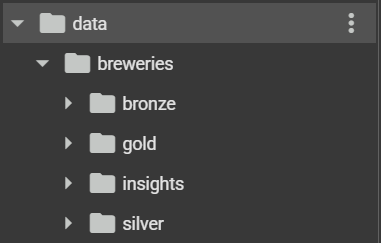

## Instalação das dependências

In [ ]:
!pip install pyspark
!pip install pandas
!pip install matplotlib
!pip install requests

## Producer e gravação da etapa Bronze do Pipeline

In [ ]:
import os
import json
import time
import requests
from datetime import datetime

# Configurações
API_URL_BASE = "https://api.openbrewerydb.org/v1/breweries"
PER_PAGE = 100
BRONZE_PATH = "data/breweries/bronze"
OUTPUT_FILE = os.path.join(BRONZE_PATH, "breweries_bronze.json")

# Garante que o diretório existe
os.makedirs(BRONZE_PATH, exist_ok=True)

def log(msg):
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {msg}")

def fetch_breweries_page(page):
    url = f"{API_URL_BASE}?sort=id:asc&page={page}&per_page={PER_PAGE}"
    try:
        response = requests.get(url, timeout=15)
        response.raise_for_status()
        data = response.json()
        return data
    except Exception as e:
        log(f"⚠️ Erro ao buscar página {page}: {e}")
        return None

def save_breweries(data):
    with open(OUTPUT_FILE, 'a', encoding='utf-8') as f:
        for brewery in data:
            enriched = {
                "json_str": json.dumps(brewery, ensure_ascii=False),
                "ts_ingestion": datetime.utcnow().isoformat()
            }
            f.write(json.dumps(enriched, ensure_ascii=False) + "\n")

def collect_all_breweries():
    page = 1
    total_saved = 0

    log("🚀 Iniciando coleta de dados da API...")

    while True:
        data = fetch_breweries_page(page)
        if data is None:
            log("⚠️ Falha na requisição. Esperando 30s antes de tentar novamente...")
            time.sleep(30)
            continue

        if len(data) == 0:
            log("✅ Fim da coleta. Nenhum dado retornado.")
            break

        log(f"📄 Página {page} coletada com {len(data)} registros.")
        save_breweries(data)
        total_saved += len(data)

        page += 1
        time.sleep(1)

    log(f"🎉 Coleta finalizada. Total de registros salvos: {total_saved}")

# Executa o processo
collect_all_breweries()


[2025-06-19 18:48:50] 🚀 Iniciando coleta de dados da API...
[2025-06-19 18:48:51] 📄 Página 1 coletada com 100 registros.
[2025-06-19 18:48:52] 📄 Página 2 coletada com 100 registros.
[2025-06-19 18:48:53] 📄 Página 3 coletada com 100 registros.
[2025-06-19 18:48:55] 📄 Página 4 coletada com 100 registros.
[2025-06-19 18:48:56] 📄 Página 5 coletada com 100 registros.
[2025-06-19 18:48:58] 📄 Página 6 coletada com 100 registros.
[2025-06-19 18:48:59] 📄 Página 7 coletada com 100 registros.
[2025-06-19 18:49:00] 📄 Página 8 coletada com 100 registros.
[2025-06-19 18:49:02] 📄 Página 9 coletada com 100 registros.
[2025-06-19 18:49:03] 📄 Página 10 coletada com 100 registros.
[2025-06-19 18:49:04] 📄 Página 11 coletada com 100 registros.
[2025-06-19 18:49:06] 📄 Página 12 coletada com 100 registros.
[2025-06-19 18:49:07] 📄 Página 13 coletada com 100 registros.
[2025-06-19 18:49:08] 📄 Página 14 coletada com 100 registros.
[2025-06-19 18:49:10] 📄 Página 15 coletada com 100 registros.
[2025-06-19 18:49:1

## Gravação da etapa Silver do Pipeline

In [ ]:
import os
import time
from datetime import datetime

from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col, current_timestamp, lit
from pyspark.sql.types import StructType, StructField, StringType, TimestampType

def log(msg):
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {msg}")

# Schema do JSON interno
json_schema = StructType([
    StructField("id", StringType(), True),
    StructField("name", StringType(), True),
    StructField("brewery_type", StringType(), True),
    StructField("street", StringType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("postal_code", StringType(), True),
    StructField("country", StringType(), True),
    StructField("longitude", StringType(), True),
    StructField("latitude", StringType(), True),
    StructField("phone", StringType(), True),
    StructField("website_url", StringType(), True),
])

# Schema da camada Bronze
bronze_schema = StructType([
    StructField("json_str", StringType(), True),
    StructField("ts_ingestion", TimestampType(), True)
])

def main():
    start_time = time.time()
    log("🚀 Iniciando transformação Bronze → Silver...")

    spark = SparkSession.builder.appName("BreweriesBronzeToSilver").getOrCreate()

    bronze_path = "data/breweries/bronze/breweries_bronze.json"
    silver_path = "data/breweries/silver"

    # Lê a Bronze
    try:
        log("📥 Lendo JSON da camada Bronze...")
        df_bronze_raw = spark.read.format("json").schema(bronze_schema).load(bronze_path)
        log(f"✅ Bronze carregada com {df_bronze_raw.count()} registros.")
    except Exception as e:
        log(f"❌ Erro ao ler Bronze: {e}")
        return

    # Parse do JSON interno
    df_parsed = df_bronze_raw.select(
        from_json(col("json_str"), json_schema).alias("data"),
        col("ts_ingestion")
    ).select("data.*", "ts_ingestion")

    # Limpeza e enriquecimento
    df_clean = df_parsed.filter(col("state").isNotNull())
    df_clean = df_clean.withColumn("created_at", current_timestamp())
    df_clean = df_clean.withColumn("updated_at", current_timestamp())

    record_count = df_clean.count()

    if record_count == 0:
        log("🚫 Nenhum dado válido para salvar na Silver.")
    else:
        log(f"💾 Salvando {record_count} registros em Parquet, particionado por estado...")
        (
            df_clean.write
            .format("parquet")
            .mode("overwrite")
            .partitionBy("state")
            .save(silver_path)
        )
        log("✅ Dados salvos com sucesso na Silver.")
        df_clean.show(10,False)

    spark.stop()
    total_time = time.time() - start_time
    log(f"🏁 Pipeline finalizado em {total_time:.2f} segundos.")

if __name__ == "__main__":
    main()


[2025-06-19 18:58:12] 🚀 Iniciando transformação Bronze → Silver...
[2025-06-19 18:58:13] 📥 Lendo JSON da camada Bronze...
[2025-06-19 18:58:14] ✅ Bronze carregada com 8375 registros.
[2025-06-19 18:58:14] 💾 Salvando 8375 registros em Parquet, particionado por estado...
[2025-06-19 18:58:21] ✅ Dados salvos com sucesso na Silver.
+------------------------------------+-----------------------------------------------+------------+-----------------------------+-------------+-------------+-----------+-------------+------------+-----------+----------+--------------------------------------------------------------------------+--------------------------+--------------------------+--------------------------+
|id                                  |name                                           |brewery_type|street                       |city         |state        |postal_code|country      |longitude   |latitude   |phone     |website_url                                                               |

## Gravação da etapa Gold do Pipeline e DataViz

[2025-06-19 19:04:05] 🔄 Iniciando pipeline Batch Gold + Visualização...
[2025-06-19 19:04:05] 📥 Lendo dados da camada prata...
[2025-06-19 19:04:09] ✅ Dados lidos da Silver: 8375 registros.
[2025-06-19 19:04:09] 📊 Gerando agregações OLAP com CUBE...
[2025-06-19 19:04:10] 💾 Salvando camada ouro...
[2025-06-19 19:04:11] ✅ Camada ouro salva com sucesso.
+------------+--------------------+-------------+
|brewery_type|state               |brewery_count|
+------------+--------------------+-------------+
|NULL        |NULL                |8375         |
|NULL        |Alabama             |45           |
|NULL        |Alaska              |51           |
|NULL        |Argyll              |4            |
|NULL        |Arizona             |125          |
|NULL        |Arkansas            |45           |
|NULL        |Aveiro              |2            |
|NULL        |Beja                |1            |
|NULL        |Berlin              |10           |
|NULL        |Blekinge            |6           

/tmp/ipython-input-12-352657186.py:80: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-12-352657186.py:82: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(tipo_path)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


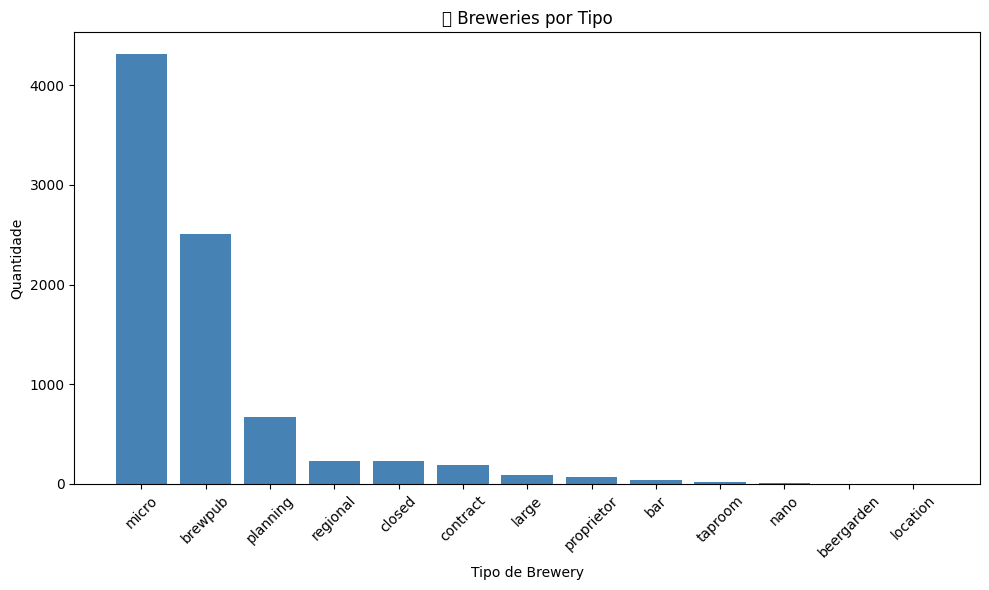

/tmp/ipython-input-12-352657186.py:99: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-12-352657186.py:101: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(estado_path)


[2025-06-19 19:04:14] ✅ Gráfico salvo em: data/breweries/insights/breweries_por_tipo.png
[2025-06-19 19:04:14] 📈 Gerando gráfico: TOP 10 estados com mais breweries...


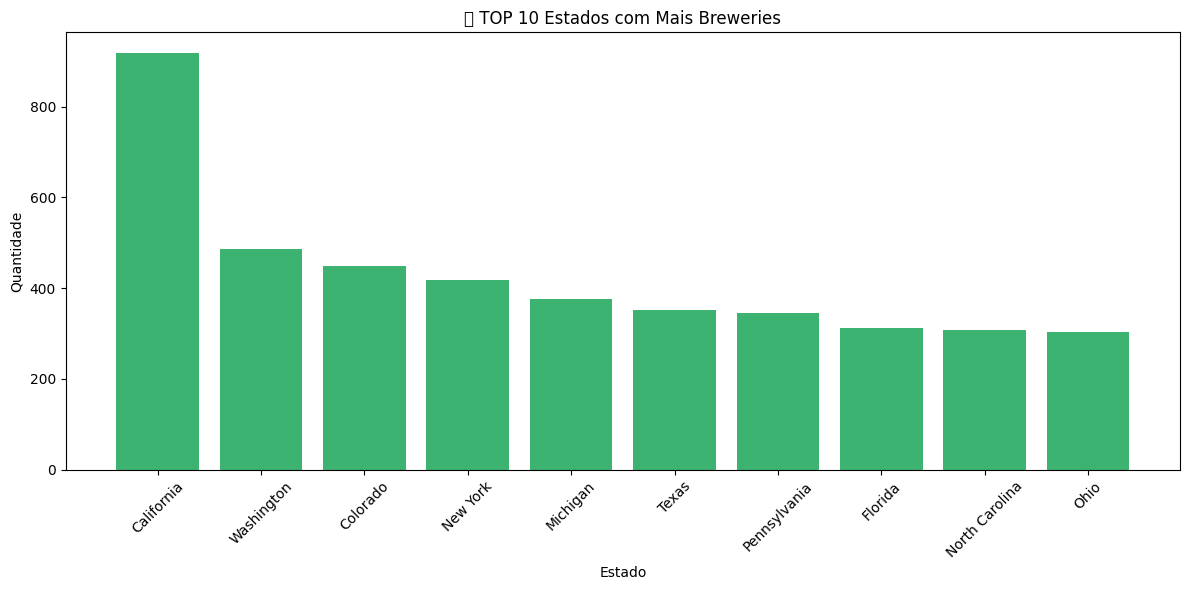

[2025-06-19 19:04:14] ✅ Gráfico salvo em: data/breweries/insights/breweries_por_estado.png
[2025-06-19 19:04:15] ✅ Pipeline finalizado com sucesso em 9.65 segundos.


In [ ]:
import os
import time
from datetime import datetime

from pyspark.sql import SparkSession
from pyspark.sql.functions import count
import pandas as pd
import matplotlib.pyplot as plt

def log(msg):
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {msg}")

def main():
    start_time = time.time()
    log("🔄 Iniciando pipeline Batch Gold + Visualização...")

    # Inicialização do Spark
    spark = (
        SparkSession.builder
        .appName("BreweriesBatchToGoldWithViz")
        .getOrCreate()
    )

    silver_path = "data/breweries/silver"
    gold_path = "data/breweries/gold"
    insight_path = "data/breweries/insights"

    # Garante que o diretório de insights existe
    os.makedirs(insight_path, exist_ok=True)

    # Etapa: Leitura da camada Silver
    try:
        log("📥 Lendo dados da camada prata...")
        df_silver = spark.read.format("parquet").load(silver_path)
        log(f"✅ Dados lidos da Silver: {df_silver.count()} registros.")
    except Exception as e:
        log(f"❌ Erro ao ler camada prata: {e}")
        return

    # Etapa: Agregações e geração da Gold
    try:
        log("📊 Gerando agregações OLAP com CUBE...")
        df_gold = (
            df_silver
            .cube("brewery_type", "state")
            .agg(count("*").alias("brewery_count"))
            .orderBy("brewery_type", "state")
        )

        log("💾 Salvando camada ouro...")
        (
            df_gold.write
            .format("parquet")
            .mode("overwrite")
            .save(gold_path)
        )
        log("✅ Camada ouro salva com sucesso.")
        df_gold.show(100,False)
    except Exception as e:
        log(f"❌ Erro ao processar/salvar camada ouro: {e}")
        return

    # Etapa: Visualização
    try:
        log("🔄 Convertendo dados para Pandas...")
        df_pandas = df_gold.toPandas()

        # Gráfico por tipo de brewery
        log("📈 Gerando gráfico: breweries por tipo...")
        df_tipo = df_pandas[
            (df_pandas["brewery_type"].notna()) & (df_pandas["state"].isna())
        ].sort_values("brewery_count", ascending=False)

        plt.figure(figsize=(10, 6))
        plt.bar(df_tipo["brewery_type"], df_tipo["brewery_count"], color="steelblue")
        plt.title("Breweries por Tipo")
        plt.xlabel("Tipo de Brewery")
        plt.ylabel("Quantidade")
        plt.xticks(rotation=45)
        plt.tight_layout()
        tipo_path = os.path.join(insight_path, "breweries_por_tipo.png")
        plt.savefig(tipo_path)
        plt.show()
        plt.close()
        log(f"✅ Gráfico salvo em: {tipo_path}")

        # Gráfico por estado
        log("📈 Gerando gráfico: TOP 10 estados com mais breweries...")
        df_estado = df_pandas[
            (df_pandas["brewery_type"].isna()) & (df_pandas["state"].notna())
        ].sort_values("brewery_count", ascending=False).head(10)

        plt.figure(figsize=(12, 6))
        plt.bar(df_estado["state"], df_estado["brewery_count"], color="mediumseagreen")
        plt.title("TOP 10 Estados com Mais Breweries")
        plt.xlabel("Estado")
        plt.ylabel("Quantidade")
        plt.xticks(rotation=45)
        plt.tight_layout()
        estado_path = os.path.join(insight_path, "breweries_por_estado.png")
        plt.savefig(estado_path)
        plt.show()
        plt.close()
        log(f"✅ Gráfico salvo em: {estado_path}")
    except Exception as e:
        log(f"❌ Erro ao gerar gráficos: {e}")
        return

    spark.stop()
    total_time = time.time() - start_time
    log(f"✅ Pipeline finalizado com sucesso em {total_time:.2f} segundos.")

if __name__ == "__main__":
    main()
